In [1628]:
%cd 'Q:\Dropbox\python\QSim\'

Q:\Dropbox\python\QSim


In [1629]:
%matplotlib inline
from scipy.io import *
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import scipy.fftpack as fft

In [1630]:
def cross(a, b):
    return [a[i]*b[i+1]-a[i+1]*b[i] for i in [1,-1,0]]

def jacobian(X):
    J = [[(np.roll(X[i],-1,j)-np.roll(X[i],1,j))*0.5 for j in range(0,3)] for i in range(0,3)]
    for i in range(0,3):
        J[i][0][0,:,:] = -1.5*X[i][0,:,:]+2*X[i][1,:,:]-0.5*X[i][2,:,:]
        J[i][0][-1,:,:] = 1.5*X[i][-1,:,:]-2*X[i][-2,:,:]+0.5*X[i][-3,:,:]
        J[i][1][:,0,:] = -1.5*X[i][:,0,:]+2*X[i][:,1,:]-0.5*X[i][:,2,:]
        J[i][1][:,-1,:] = 1.5*X[i][:,-1,:]-2*X[i][:,-2,:]+0.5*X[i][:,-3,:]
        J[i][2][:,:,0] = -1.5*X[i][:,:,0]+2*X[i][:,:,1]-0.5*X[i][:,:,2]
        J[i][2][:,:,-1] = 1.5*X[i][:,:,-1]-2*X[i][:,:,-2]+0.5*X[i][:,:,-3]  
        
    return J


def hessian(X):
    J = jacobian(X)   
    H = [[[(-2*X[i] + np.roll(X[i],-1,k)+np.roll(X[i],1,k)) if k == j else 
           (np.roll(J[i][j],-1,k)-np.roll(J[i][j],1,k))*0.5 for k in range(0,j+1)] for j in range(0,3)] for i in range(0,3)]
    
    for i in range(0,3):
        
        H[i][0][0][0,:,:] = 2*X[i][0,:,:]-5*X[i][1,:,:]+4*X[i][2,:,:]-X[i][3,:,:]
        H[i][0][0][-1,:,:] = 2*X[i][-1,:,:]-5*X[i][-2,:,:]+4*X[i][-3,:,:]-X[i][-4,:,:]
        H[i][1][1][:,0,:] = 2*X[i][:,0,:]-5*X[i][:,1,:]+4*X[i][:,2,:]-X[i][:,3,:]
        H[i][1][1][:,-1,:] = 2*X[i][:,-1,:]-5*X[i][:,-2,:]+4*X[i][:,-3,:]-X[i][:,-4,:]
        H[i][2][2][:,:,0] = 2*X[i][:,:,0]-5*X[i][:,:,1]+4*X[i][:,:,2]-X[i][:,:,3]
        H[i][2][2][:,:,-1] = 2*X[i][:,:,-1]-5*X[i][:,:,-2]+4*X[i][:,:,-3]-X[i][:,:,-4]
        
        
        
        for j in (1,2):
            H[i][j][0][0,:,:] = -1.5*J[i][j][0,:,:]+2*J[i][j][1,:,:]-0.5*J[i][j][2,:,:]
            H[i][j][0][-1,:,:] = 1.5*J[i][j][-1,:,:]-2*J[i][j][-2,:,:]+0.5*J[i][j][-3,:,:]

        
        H[i][2][1][:,0,:] = -1.5*J[i][2][:,0,:]+2*J[i][2][:,1,:]-0.5*J[i][2][:,2,:]
        H[i][2][1][:,-1,:] = 1.5*J[i][2][:,-1,:]-2*J[i][2][:,-2,:]+0.5*J[i][2][:,-3,:]
        

    return (H, J)    

def det(a):
    return np.sum([a[0][i-1]*(a[1][i]*a[2][i+1]-a[1][i+1]*a[2][i]) for i in [1,-1,0]],0)

def rot(B, X):
    hes = hessian(X)
    J = hes[1]
    H = hes[0]
    detJ = det(J)
    Jb = [[(J[i][j]*J[i+1][j+1] - J[i+1][j]*J[i][j+1])/detJ for j in [-2,-1,0]] for i in [1,-1,0]]
    dB = [np.gradient(B[i]) for i in range(0,3)]
    Bx = [np.sum([J[i][j]*B[j] for j in range(0,3)]/detJ,0) for i in range(0,3)]
  
    DdetJ = [det([[H[i][j][0],J[i][1],J[i][2]] for i in range(0,3)])+
            det([[J[i][0],H[i][max(j,1)][min(j,1)],J[i][2]] for i in range(0,3)])+
            det([[J[i][0],J[i][1],H[i][max(j,2)][min(j,2)]] for i in range(0,3)]) for j in range(0,3)]

    dBx = [[(H[i][2][j]*B[2] - DdetJ[j]*Bx[i])/detJ for j in range(0,3)] for i in range(0,3)]
    
    rotB = [np.sum([Jb[i][j]*dBx[i+1][j]-Jb[i+1][j]*dBx[i][j] for j in range(0,3)],0) for i in [1,-1,0]]
    
    force = [np.sum([B[j]*dBx[i][j]/detJ - np.sum([Bx[k]*dBx[k][j] for k in range(0,3)],0)*Jb[i][j] for j in range(0,3)],0) for i in range(0,3)]
    
    #A = [[np.sum([dBx[k][j]*Jb[i][j] for j in range(0,3)],0) for k in range(0,3)] for i in range(0,3)]
    #b = [dBx[i][2] for i in range(0,3)]
    
    return (force, rotB)



In [1711]:
dim = [64,64,64]
X = np.mgrid[0:dim[0], 0:dim[1], 0:dim[2]].astype(np.float64)
B = [np.zeros(dim) for i in range(0,3)]
B[2] = np.ones(dim)
X1 = np.array(X)
ar = 6**2
az = 8**2
t = X[2]/(dim[2]-1)
#h = np.exp(-((X[0]-dim[0]/2)**2 + (X[1]-dim[1]/2)**2)/ar)*np.cos(np.pi*X[2]/dim[2])*np.pi/8
h = np.exp(-((X[0]-dim[0]/2)**2 + (X[1]-dim[1]/2)**2)/ar - (X[2])**2/az)*np.pi/8

X[0] = (X1[0]-dim[0]/2)*np.cos(h) - (X1[1]-dim[1]/2)*np.sin(h) + dim[0]/2
X[1] = (X1[0]-dim[0]/2)*np.sin(h) + (X1[1]-dim[1]/2)*np.cos(h) + dim[1]/2

#X[1] = X[1] + (X[0]-dim[0]/2)*np.exp(-np.abs(X[0]-dim[0]/2)/2)*np.cos(np.pi*X[2]/dim[2])


X1 = np.array(X)
force = rot(B, X1)[0]
print np.max(np.abs(force))

0.0357283919325


In [1735]:
niter = 1
q = 1e-1

for k in range(0,niter):
    hes = hessian(X1)

    J = hes[1]
    H = hes[0]
    detJ = det(J)
    DdetJ = [det([[H[i][j][0],J[i][1],J[i][2]] for i in range(0,3)])+
                det([[J[i][0],H[i][max(j,1)][min(j,1)],J[i][2]] for i in range(0,3)])+
                det([[J[i][0],J[i][1],H[i][max(j,2)][min(j,2)]] for i in range(0,3)]) for j in range(0,3)]

    Hz = [[H[i][2][j] for j in range(0,3)] for i in range(0,3)]
    Jb = [[(J[i][j]*J[i+1][j+1] - J[i+1][j]*J[i][j+1])/detJ for j in [-2,-1,0]] for i in [1,-1,0]]

    #A = [np.sum([np.sum([(Hz[j][k]-DdetJ[k]/detJ*J[j][2])*Jb[i][k] for k in range(0,3)],0)*
    #             J[j][2] for j in range(0,3)],0) + DdetJ[2]/detJ*J[i][2] - Hz[i][2] for i in range(0,3)]

    A = [(np.sum([np.sum([Hz[j][k]*Jb[i][k] for k in range(0,3)],0)*
                 J[j][2] for j in range(0,3)],0) - Hz[i][2]) for i in range(0,3)]

    freq = 2*(np.cos(np.pi*np.arange(1,dim[2]-1)/(dim[2]-1))-1)
    fA = [fft.idst(fft.dst(A[i][:,:,1:-1],axis=2, type=1)/freq, axis=2, type=1)/(2*dim[2]-2) for i in range(0,3)]

    X1[0][:,:,1:-1] = X1[0][:,:,1:-1] + fA[0]*q
    X1[1][:,:,1:-1] = X1[1][:,:,1:-1] + fA[1]*q
    X1[2][:,:,1:-1] = X1[2][:,:,1:-1] + fA[2]*q

    
    #B = [np.sum([DdetJ[k]*Jb[i][k] + DdetJ[2]*J[i][2] for k in range(0,3)],0)*
    #             np.sum([J[j][2]**2 for j in range(0,3)],0)/(DdetJ[2]+1) - J[i][2] for i in range(0,3)]

    #freq = 2*np.sin(np.pi*np.arange(1,dim[2]-1)/(dim[2]-1))
    #fB = [fft.idst(fft.dst(B[i][:,:,1:-1],axis=2, type=1)/freq, axis=2, type=1)/(2*dim[2]-2) for i in range(0,3)]

    #X1[0][:,:,1:-1] = X1[0][:,:,1:-1] + fB[0]*q
    #X1[1][:,:,1:-1] = X1[1][:,:,1:-1] + fB[1]*q
    #X1[2][:,:,1:-1] = X1[2][:,:,1:-1] + fB[2]*q
    
    
    
    

print np.min(detJ)
print np.max(np.abs((Hz[1][2] - A[1])[:,:,2:-2]))

force = rot(B, X1)[0]
print np.max(np.abs(force))


0.940407533015
0.00455962712738
0.0284024345768


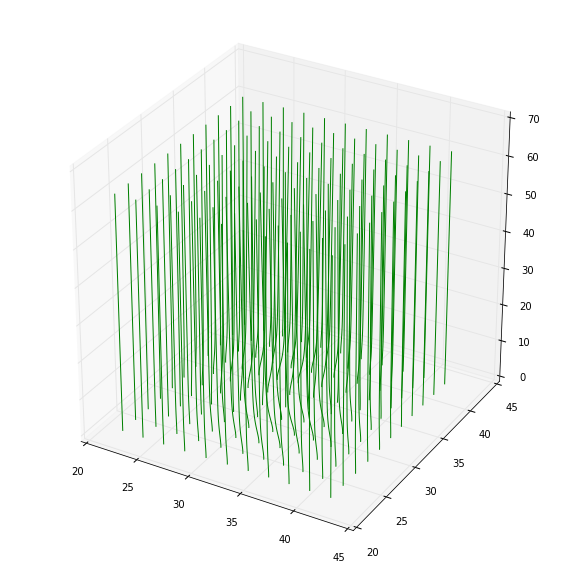

In [1705]:
%matplotlib inline
fig = plt.figure(0,[10,10])
ax = fig.add_subplot(111, projection='3d')
for i in range(22, 43, 2):
    for j in range(22, 43, 2):
        ax.plot(X1[0][i,j,:],X1[1][i,j,:],X1[2][i,j,:], color = 'green')
plt.show()

In [1588]:
rotB = rot(B,X1)[1]
plt.imshow(rotB[2][:,:,30])

C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:34: RuntimeWarning: overflow encountered in multiply
C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:34: RuntimeWarning: invalid value encountered in subtract
C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:41: RuntimeWarning: overflow encountered in multiply
C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:41: RuntimeWarning: invalid value encountered in subtract
C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:41: RuntimeWarning: invalid value encountered in divide
C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:41: RuntimeWarning: overflow encountered in subtract
C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:34: RuntimeWarning: overflow encountered in subtract
C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:47: RuntimeWarning: invalid value encountered in add
C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:49: RuntimeWarning: invalid value encountered in m